In [94]:
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
from datasets import load_dataset

dataset = load_dataset('glue', 'sst2')
train_data = dataset['train']
test_data = dataset['validation']

  0%|          | 0/3 [00:00<?, ?it/s]

In [96]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip.1

In [97]:
# !pip install torchmetrics

In [98]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchtext
import nltk
from nltk.tokenize import word_tokenize
import math
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
# import torchmetrics
from nltk.corpus import wordnet
import torch.nn.functional as F
from torch.autograd import Variable
from nltk.corpus import stopwords, opinion_lexicon

In [99]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
nltk.download('stopwords')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [101]:
# df = pd.DataFrame(data = train_data, index = list(range(1, train_data.num_rows + 1)), columns = train_data.column_names)
# df.head()
# df['sentence']

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
%cd /content/drive/MyDrive/NLP/glove

/content/drive/MyDrive/NLP/glove


In [104]:
#loading the glove embeddings

def load_glove_embeddings(path):
    with open(path,'r') as f:
        embeddings = {}
        for line in f:
            line = line.split()
            word = line[0]
            vec = np.array([float(val) for val in line[1:]])
            embeddings[word] = vec
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

In [105]:
def tokenize(sentence):
  tokens = word_tokenize(sentence)

  return tokens

In [106]:
max_sequence_length = max(max(len(tokenize(example)), len(tokenize(example))) for example in train_data['sentence'])

def tokens_to_embeddings(tokens, embeddings, max_sequence_length):
  embedded = []
  for token in tokens:
    if token in embeddings:
      vector = embeddings[token]

    else:
      vector = np.zeros((100,))

    embedded.append(vector)
    # print(len(embedded))

  if len(embedded) < max_sequence_length:
    padding = np.zeros((max_sequence_length - len(embedded), 100))
    embedded.extend(padding)



  return torch.tensor(embedded)

In [107]:
#computing the maximum sequence length of the input

# max_sequence_length = max(max(len(tokenize(example)), len(tokenize(example))) for example in train_data['sentence'])
# print(max_sequence_length)

In [108]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, embeddings):
        self.sentences = dataset['sentence']
        self.labels = dataset['label']
        self.embeddings = embeddings

    def __len__(self):
      # returns number of sentences
        return len(self.sentences)

    def __getitem__(self, idx):
      #loads and returns a sample from the dataset
        sentence = self.sentences[idx]
        label = self.labels[idx]
        tokens = tokenize(sentence)
        vector = tokens_to_embeddings(tokens, self.embeddings, max_sequence_length)
        # vector = sentence_to_embedding(sentence, glove_embeddings)
        return vector, label


train_dataset = SentenceDataset(dataset['train'], glove_embeddings)
test_dataset = SentenceDataset(dataset['validation'], glove_embeddings)
_, label = train_dataset.__getitem__(2)
print("Number of sentences: ", train_dataset.__len__())

Number of sentences:  67349


In [109]:
class AdvSentenceDataset(Dataset):
    def __init__(self, token_sequences, labels, embeddings, max_len):
        self.sentences = token_sequences
        self.labels = labels
        self.embeddings = embeddings
        self.max_len = max_len

    def __len__(self):
      # returns number of sentences
        return len(self.sentences)

    def __getitem__(self, idx):
      #loads and returns a sample from the dataset
        tokens = self.sentences[idx]
        label = self.labels[idx]
        # tokens = tokenize(sentence)
        vector = tokens_to_embeddings(tokens, self.embeddings, max_sequence_length)
        # vector = sentence_to_embedding(sentence, glove_embeddings)
        return vector, label


In [110]:
copy_train_dataset_original = train_data
copy_test_dataset_original = test_data

print(f"Number of total training examples: {len(copy_train_dataset_original)}")
print(f"Number of total test examples: {len(copy_test_dataset_original)}")

num_samples = len(copy_train_dataset_original)
val_fraction = (num_samples - 50000) / num_samples
dataset_trainval = copy_train_dataset_original.train_test_split(test_size=val_fraction, seed=42)

train_data_new = dataset_trainval['train']
valid_data = dataset_trainval['test']

print(f'Train dataset length: {len(train_data_new)}')
print(f'Validation dataset length: {len(valid_data)}')
print(f"Dataset features: {train_data.features}")

Number of total training examples: 67349
Number of total test examples: 872
Train dataset length: 50000
Validation dataset length: 17349
Dataset features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}


In [111]:
num_samples_adv = len(copy_test_dataset_original)
val_fraction_adv = (num_samples_adv - 800) / num_samples_adv
dataset_traintest = copy_test_dataset_original.train_test_split(test_size=val_fraction_adv, seed=42)

train_data_adv = dataset_traintest['train']
valid_data_adv = dataset_traintest['test']

print(f'Train dataset length: {len(train_data_adv)}')
print(f'Validation dataset length: {len(valid_data_adv)}')
print(f"Dataset features: {train_data_adv.features}")


Train dataset length: 800
Validation dataset length: 72
Dataset features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}


In [112]:
train_dataset_new = SentenceDataset(train_data, glove_embeddings)
test_dataset_new = SentenceDataset(valid_data, glove_embeddings)

In [113]:
train_loader_new = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_new = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [114]:
glove = GloVe(name='6B', dim=100)

In [115]:
def find_similar_words(word, top_k=5):
    word_vector = glove.vectors[glove.stoi[word]]
    distances = torch.cosine_similarity(glove.vectors, word_vector.unsqueeze(0))
    _, indices = torch.topk(distances, top_k+1)  # Exclude the word itself
    similar_words = [glove.itos[idx] for idx in indices.tolist() if glove.itos[idx] != word]
    return similar_words


In [116]:
DEFAULT_IGNORE_TOKENS = ["@@NULL@@", ".", ",", ";", "!", "?", "[MASK]", "[SEP]", "[CLS]"]
def k_similar_words(embedding, vocab, top_k = 5):
  distances = torch.cosine_similarity(vocab.vectors, embedding)
  _, indices = torch.topk(distances, top_k+1)
  similar_words = [vocab.itos[idx] for idx in indices.tolist() if not torch.equal(vocab.vectors[idx], embedding)]
  words = []
  for word in similar_words:
    if word not in DEFAULT_IGNORE_TOKENS:
      words.append(word)

  return words

In [117]:
w = glove['hello']

print(k_similar_words(w, glove, 10))

['goodbye', 'hey', 'yeah', 'dear', 'mister', 'wow', 'muddah', 'mama', 'thank']


In [118]:
def return_word(embedding, vectors):
  distances = torch.norm(glove.vectors - embedding, dim=1)
  # print(embedding.shape)
  closest_index = torch.argmin(distances)
  token = glove.itos[closest_index]
  return token


In [119]:
def return_sentece(sentence, vectors):
  output_sentence = []
  for i in range(sentence.shape[0]):
    distances = torch.norm(glove.vectors - sentence[i], dim=1)
    closest_index = torch.argmin(distances)
    tok = glove.itos[closest_index]
    output_sentence.append(tok)

  return output_sentence

##Model Architecture

In [120]:
# !pip install torchtext==0.4

In [121]:
class Sentiment_Classifier(nn.Module):
  def __init__(self,  embed_dim, out_dim, attention_heads, max_length = 53):
    super(Sentiment_Classifier, self).__init__()

    self.attention = nn.MultiheadAttention(embed_dim = embed_dim, num_heads=attention_heads)
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.fc1 = nn.Linear(embed_dim, embed_dim)
    self.layer_norm2 = nn.LayerNorm(embed_dim)

    self.attention2 = nn.MultiheadAttention(embed_dim = embed_dim, num_heads=attention_heads)
    self.layer_norm3 = nn.LayerNorm(embed_dim)
    self.fc2 = nn.Linear(embed_dim, embed_dim)
    self.layer_norm4 = nn.LayerNorm(embed_dim)

    self.fc = nn.Linear(embed_dim, out_dim)
    self.position_embedding = nn.Embedding(max_length, embed_dim)
    self.max_length = max_length


  def forward(self, x):


    #obtaining the position indices and the position embeddings

    positions = torch.arange(self.max_length).unsqueeze(0)
    positions = positions.expand(x.size(0), -1)
    position_embedded = self.position_embedding(positions)

    #adding the position embeddings to the input

    x = x + position_embedded

    x = torch.sum(x, dim=1)/53


    x1, _ = self.attention(x, x, x)

    x2 = self.layer_norm1(x + x1)
    x3 = self.fc1(x2)
    x4 = self.layer_norm2(x3 + x2)

    x5, _ = self.attention2(x4, x4, x4)
    x6 = self.layer_norm3(x5 + x4)
    x7 = self.fc2(x6)
    outputs = self.layer_norm4(x7 + x6)


    y = self.fc(outputs)
    return y



In [122]:
embed_dim = 100
num_classes = 2
attention_heads = 5

model = Sentiment_Classifier(embed_dim, num_classes, attention_heads)
print(model)

Sentiment_Classifier(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (attention2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm4): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (position_embedding): Embedding(53, 100)
)


In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Define the training loop

In [124]:
def train(model, optimizer, criterion, num_epochs):

  avg_loss = 0
  correct = 0
  total = 0

  losses = []

  # Switch to train mode
  model.train()
  epoch = 0

  for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    # epoch =+ 1

    avg_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader_new):
        data = data.to(device=device).float()
        targets = targets.to(device=device).long()
        # print(targets)


        scores = model(data)
        # print(scores)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss.item()
        _, predicted = torch.max(scores, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = avg_loss/len(train_loader_new)
    losses.append(train_loss)
    accuracy = correct/total


  return losses, accuracy

In [ ]:
num_epochs = 35
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adagrad(model.parameters())
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

losses, accuracy = train(model, optimizer, criterion, num_epochs)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34


In [ ]:
print(accuracy)
print(model)

0.8107618524402738
Sentiment_Classifier(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (attention2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm4): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (position_embedding): Embedding(53, 100)
)


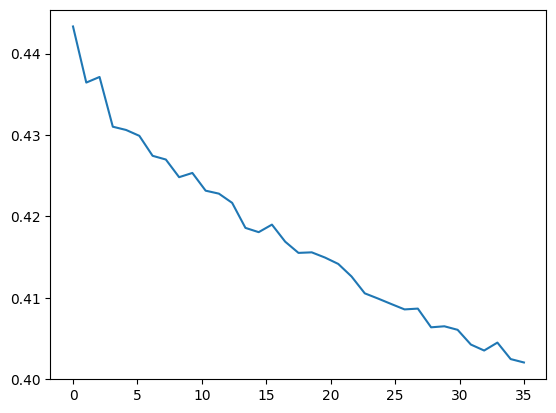

In [ ]:
plt.plot(np.linspace(0, len(losses), len(losses)), losses)

In [ ]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [ ]:
# torch.save(model.state_dict(), './self_att_35_100d')
# LOSS = losses[-1]
# torch.save({'epoch': 30, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': LOSS}, './self_att_35_100d_full')

#self_att_new_adam_30 - self attention with two attention layers trained for 30 epochs with lr = 0.0001
# np.save(checkpoint_dir + "losses", losses)

In [ ]:
mod = Sentiment_Classifier(embed_dim, num_classes, attention_heads)
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('/content/drive/MyDrive/NLP/self_att_35_100d_full')
mod.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.train()


Sentiment_Classifier(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (attention2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
  )
  (layer_norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (layer_norm4): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (position_embedding): Embedding(53, 100)
)

In [ ]:
losses_resumed, accuracy_resumed = train(mod, optimizer1, criterion, 10)
print(accuracy_resumed)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
0.8113557736566245


In [ ]:
print(accuracy_resumed)

0.844481729498582


In [ ]:
LOSS_RES = losses_resumed[-1]
torch.save({'epoch': 30, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': LOSS_RES}, './self_att_35_100d_full')

35


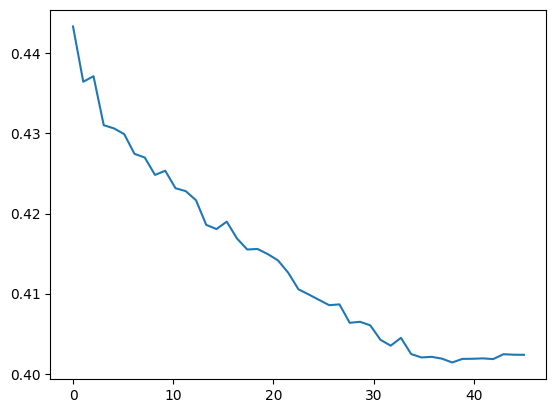

In [ ]:
# losses = losses[:30]
print(len(losses))
loss_tot = losses
loss_tot.extend(losses_resumed)
plt.plot(np.linspace(0, len(loss_tot), len(loss_tot)), loss_tot)

In [125]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).float()
            y = y.to(device=device).long()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return num_correct/num_samples

print(f'Accuracy on test data: {check_accuracy(test_loader_new, model)*100:.2f}')

Accuracy on test data: 50.92


## Hot Flip

In [126]:
vocab = GloVe(name='6B', dim=100)
sentence = "this is bad"

tokens = tokenize(sentence)

classifier = Sentiment_Classifier(embed_dim, num_classes, 5)
checkpoint = torch.load('/content/drive/MyDrive/NLP/self_att_35_100d_full')
classifier.load_state_dict(checkpoint['model_state_dict'])
classifier.eval()
print(f'Accuracy on test data: {check_accuracy(test_loader_new, classifier)*100:.2f}')


Accuracy on test data: 77.18


In [127]:
embeddings = {word: vector.numpy() for word, vector in zip(vocab.itos, vocab.vectors)}

In [128]:
DEFAULT_IGNORE_TOKENS = ["@@NULL@@", ".", ",", ";", "!", "?", "[MASK]", "[SEP]", "[CLS]", '"']
stop_words = set(stopwords.words('english'))
opinion_words = set(opinion_lexicon.words())
ignore_tokens = set(DEFAULT_IGNORE_TOKENS) | stop_words | opinion_words

class HotFlipAdversary:
  def __init__(self, model, loader, vocab, ignore_tokens):
    self.model = model
    self.loader = loader
    self.embeddings = vocab
    self.ignore_tokens = ignore_tokens

  def hotflip_attack(self, input_sentence, input_ids, true_label):
    """
    Performs the hotflip attack by calculating the gradient of the loss with respect to the input,
    and then flipping the word that would cause the greatest increase in the loss.

    :param model: The model to attack.
    :param input_ids: The input to the model, which will be attacked.
    :param true_label: The true label of the input.
    # :param tokenizer: The tokenizer used by the model.
    :return: The adversarial example.
    """

    sentence_length = len(word_tokenize(input_sentence))

    # Create tensors
    input_ids = torch.from_numpy(input_ids)
    true_label = torch.tensor([true_label])

    # We want to compute gradients with respect to input, so we need to set requires_grad
    input_ids = input_ids.to(device=device).float()
    true_label = true_label.to(device=device).long()
    input_ids = input_ids.unsqueeze(0) # Create batch of size 1
    input_ids.requires_grad = True
    input_ids.retain_grad()

    # Forward pass
    outputs = model(input_ids)

    initial_pred = outputs.argmax(dim=1)[0]

    # Calculate the loss
    loss = F.cross_entropy(outputs, true_label)

    # Calculate gradients
    loss.backward()

    # Get gradient for input
    grads = input_ids.grad
    grads = grads.squeeze(0)
    grads = grads[:sentence_length, :]

    flipped = []
    tokenized_input = word_tokenize(input_sentence)
    for index, token in enumerate(tokenized_input):
      if token in ignore_tokens:
        flipped.append(index)


    grads_magnitude = torch.einsum('ij,ij->i', grads, grads)

    # only flip a token once
    for index in flipped:
      grads_magnitude[index] = -1

    if torch.max(grads_magnitude) == -1:
      return tokenized_input, -1

    # We flip the token with highest gradient norm.
    index_of_token_to_flip = torch.argmax(grads_magnitude)
    print('index_of_token_to_flip', index_of_token_to_flip)

    flipped.append(index_of_token_to_flip)

    # original_word = vocab[tokenized_input[index_of_token_to_flip]]

    # similar_word = k_similar_words(original_word, vocab, 10)

    # adv = tokenized_input
    # max_increase = 0

    # for word in similar_word:

    #     adv[index_of_token_to_flip] = word
    #     new_adv = tokens_to_embeddings(adv, glove_embeddings, 53)
    #     print(new_adv.shape)
    #     outputs = model(new_adv.float()).argmax(dim=1)[0]
    #     loss = F.cross_entropy(outputs, true_label)
    #     if loss > max_increase:
    #         max_increase = loss
    #         new_token = word
    #         # adv[max_grad_idx] = adversarial_word
    #     else:
    #       continue

    new_token = self.first_order_taylor(grads[index_of_token_to_flip], tokenized_input[index_of_token_to_flip])
    print(f'Adversarial: {new_token}')

    prev_token = tokenized_input[index_of_token_to_flip] # .item()
    new_grads = torch.clone(input_ids[0])

    new_grads[index_of_token_to_flip] = torch.from_numpy(embeddings[new_token])
    new_outputs = model(new_grads.unsqueeze(0))

    new_pred = new_outputs.argmax(dim=1)[0]
    print(f'Flip succesful? {new_pred == initial_pred}')


    adversarial_sentence = tokenized_input.copy()
    adversarial_sentence[index_of_token_to_flip] = new_token
    # print(f'New sentence: {adversarial_sentence}')

    return adversarial_sentence, index_of_token_to_flip

  # TODO
  def hotflip_attack_grouped(self, loader, rest):

    for batch_idx, (data, targets) in enumerate(loader):
      data = data.to(device=device).float()
      targets = targets.to(device=device).long()

      # Forward pass
      scores = model(data)
      loss = criterion(scores, targets)
      _, predictions = scores.max(1)

      # Calculate the loss
      loss = criterion(scores, targets)

      # Calculate gradients
      loss.backward()

      grads = data.grad

      grads_magnitude = torch.einsum('ij,ij->i', grads, grads)

  # Working on this
  def simple_hotflip_data_generator(self, dataset):
    adversarial_examples = []
    labels = []
    all_positions = []
    count = 0

    for instance in dataset:
      input_sentence = instance['sentence']
      input_tensor = tokens_to_embeddings(word_tokenize(input_sentence), glove_embeddings, 53)
      input_tensor = input_tensor.to(device=device).float()
      input_label = instance['label']

      adv_sentence, position = self.hotflip_attack(input_sentence, input_ids, input_label)
      adversarial_examples.append(adv_sentence)
      labels.append(input_label)
      all_positions.append(position)

      print(count)
      count += 1

    return adversarial_examples, labels, all_positions


  def first_order_taylor(self, grad, token):
    """
    Replaces the current token with another token to increase the loss.
    """

    if token in embeddings:
      word_embedding = torch.from_numpy(embeddings[token]).to(device=device)
    else:
      word_embedding = torch.zeros(100)

    # f(x + delta) = f(x) + f'(x) * delta
    # delta: v - x -> difference in embeddings -> for adv_token in embeddings: delta = embeddings[x_token] - embeddings[adv_token]  ([100])
    max_delta, adv = max(((-1 * (word_embedding - torch.from_numpy(embeddings[adv_token]).to(device=device)).dot(grad)).detach().cpu(), adv_token) for adv_token in embeddings if adv_token not in ignore_tokens)

    return adv
    # f'(x): gradient of that specific token based on the input grad_x = grad[x_id]  ([100])
    #grad
    # f(x): is prediction of original thus dimensions shouldn't matter



In [129]:
loss_fn = nn.CrossEntropyLoss()

adversary = HotFlipAdversary(classifier, test_loader_new, vocab, ignore_tokens)

In [130]:
input_sentence = test_data['sentence'][2]
print(input_sentence)
input_ids = tokens_to_embeddings(tokenize(input_sentence), embeddings, 53).numpy()
true_label = test_data['label'][2]
print(true_label)

allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
1


In [131]:
adversarial_example = adversary.hotflip_attack(input_sentence, input_ids, true_label)

index_of_token_to_flip tensor(0)
Adversarial: dnp
Flip succesful? True


In [132]:
# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [133]:
adversarial_examples_val, labels_val, pos_val = adversary.simple_hotflip_data_generator(valid_data_adv)

index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
0
index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
1
index_of_token_to_flip tensor(3)
Adversarial: dnp
Flip succesful? True
2
index_of_token_to_flip tensor(0)
Adversarial: dnp
Flip succesful? True
3
index_of_token_to_flip tensor(0)
Adversarial: dnp
Flip succesful? True
4
index_of_token_to_flip tensor(2)
Adversarial: abimael
Flip succesful? True
5
index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
6
index_of_token_to_flip tensor(2)
Adversarial: abimael
Flip succesful? True
7
index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
8
index_of_token_to_flip tensor(1)
Adversarial: abimael
Flip succesful? True
9
index_of_token_to_flip tensor(2)
Adversarial: abimael
Flip succesful? True
10
index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
11
index_of_token_to_flip tensor(1)
Adversarial: dnp
Flip succesful? True
12
index_of_token_to_flip tensor(0)

In [134]:
print(adversarial_examples_val)

[['it', 'dnp', 'onto', 'the', 'screen', 'just', 'about', 'as', 'much', 'of', 'the', 'novella', 'as', 'one', 'could', 'reasonably', 'expect', ',', 'and', 'is', 'engrossing', 'and', 'moving', 'in', 'its', 'own', 'right', '.'], ['my', 'dnp', 'fat', 'greek', 'wedding', 'uses', 'stereotypes', 'in', 'a', 'delightful', 'blend', 'of', 'sweet', 'romance', 'and', 'lovingly', 'dished', 'out', 'humor', '.'], ['for', 'the', 'most', 'dnp', ',', 'director', 'anne-sophie', 'birot', "'s", 'first', 'feature', 'is', 'a', 'sensitive', ',', 'extraordinarily', 'well-acted', 'drama', '.'], ['dnp', "'s", 'reflection', 'of', 'artists', 'and', 'the', 'love', 'of', 'cinema-and-self', 'suggests', 'nothing', 'less', 'than', 'a', 'new', 'voice', 'that', 'deserves', 'to', 'be', 'considered', 'as', 'a', 'possible', 'successor', 'to', 'the', 'best', 'european', 'directors', '.'], ['dnp', "'", 'entertaining', 'film', 'chronicles', 'seinfeld', "'s", 'return', 'to', 'stand-up', 'comedy', 'after', 'the', 'wrap', 'of', 'hi

In [135]:
val_adv_dataset = AdvSentenceDataset(adversarial_examples_val, labels_val, embeddings, 53)
val_adv_loader = DataLoader(val_adv_dataset, batch_size=2, shuffle=False)
print(val_adv_dataset.__getitem__(0))

(tensor([[-0.3066,  0.1682,  0.9851,  ..., -0.3877,  0.3692,  0.5452],
        [ 0.1823, -0.2706,  0.5726,  ..., -0.3631, -1.1676, -0.3242],
        [-0.5143,  0.0477,  0.2928,  ...,  0.7198,  0.9968,  0.0134],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64), 1)


In [137]:
def check_accuracy_adv(loader, model):
    num_correct = 0
    num_samples = 0
    softmax = torch.nn.Softmax(dim=1)
    num_missclassifed = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).float()
            y = y.to(device=device).long()

            scores = model(x)
            predictions = torch.max(softmax(scores), dim=1)[1]
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    success = ((num_samples - num_correct)/num_samples)*100
    print('Attack success rate: ', success.numpy())

    # model.train()
    return num_correct / num_samples

print(f'Accuracy on adversarial test data: {check_accuracy_adv(val_adv_loader, classifier)*100:.2f}')

Attack success rate:  68.05556
Accuracy on adversarial test data: 31.94


##Result visualization

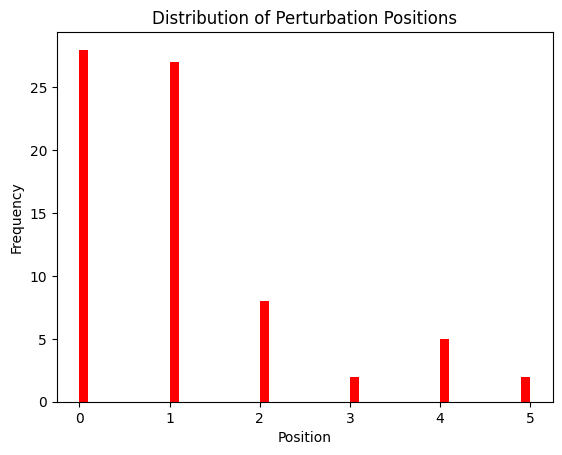

In [138]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(pos_val, bins=50, color="red")
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Distribution of Perturbation Positions')
plt.show()

In [145]:
def get_sentences(loader):
    sentences = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).float()
            y = y.to(device=device).long()

            sentences.append(x.numpy())

    return sentences

In [152]:
ad_sentences = []
for example in adversarial_examples_val:
  i = tokens_to_embeddings(example, glove_embeddings, 53)
  ad_sentences.append(i.flatten().numpy())


In [153]:
print(ad_sentences)

[array([-0.30664,  0.16821,  0.98511, ...,  0.     ,  0.     ,  0.     ]), array([ 0.080273, -0.10861 ,  0.72067 , ...,  0.      ,  0.      ,
        0.      ]), array([-0.14401,  0.32554,  0.14257, ...,  0.     ,  0.     ,  0.     ]), array([ 0.18234, -0.27061,  0.57262, ...,  0.     ,  0.     ,  0.     ]), array([ 0.18234, -0.27061,  0.57262, ...,  0.     ,  0.     ,  0.     ]), array([-0.071953,  0.23127 ,  0.023731, ...,  0.      ,  0.      ,
        0.      ]), array([-0.038194, -0.24487 ,  0.72812 , ...,  0.      ,  0.      ,
        0.      ]), array([0.31039, 0.64859, 0.28481, ..., 0.     , 0.     , 0.     ]), array([-0.038194, -0.24487 ,  0.72812 , ...,  0.      ,  0.      ,
        0.      ]), array([-0.6104 ,  0.28971,  0.62573, ...,  0.     ,  0.     ,  0.     ]), array([-0.038194, -0.24487 ,  0.72812 , ...,  0.      ,  0.      ,
        0.      ]), array([-0.49886,  0.76602,  0.89751, ...,  0.     ,  0.     ,  0.     ]), array([-0.27086 ,  0.044006, -0.02026 , ...,  0.    

In [140]:
print(val_adv_dataset.__getitem__(0))

(tensor([[-0.3066,  0.1682,  0.9851,  ..., -0.3877,  0.3692,  0.5452],
        [ 0.1823, -0.2706,  0.5726,  ..., -0.3631, -1.1676, -0.3242],
        [-0.5143,  0.0477,  0.2928,  ...,  0.7198,  0.9968,  0.0134],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64), 1)


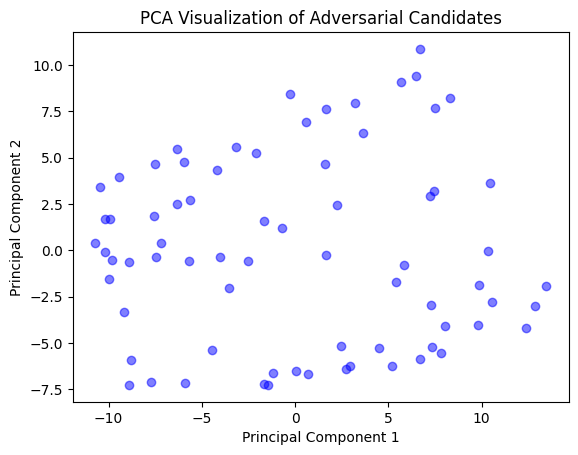

In [154]:
from sklearn.decomposition import PCA
import numpy as np

adversarial_examples_np = np.array(ad_sentences)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(adversarial_examples_np)

# Create a scatter plot
plt.scatter(principal_components[:, 0], principal_components[:, 1], color='b', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Adversarial Candidates')
plt.show()